# Twitter Sentiment Analysis to predict outcome of the 2020 US presidential elections

# Team Members
Abhishek Bais, Wasae Qureshi, Samer Baslan

# Import packages

In [ ]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import json
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Mount Google Drive
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


# Read in training tweets

In [ ]:
# Read in the twitter training data
df = pd.read_csv('/content/drive/My Drive/256/256_sentiment_labeled_tweets.csv', encoding="ISO-8859-1")
pd.set_option('display.max_colwidth', -1)
df.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,ItemID,Sentiment,Tweet
0,1,0,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
4,5,0,i think mi bf is cheating on me!!! T_T


In [ ]:
# Report the number of entries in training dataset
df.shape

(99989, 3)

In [ ]:
# Inspect training data for missing entries
df.isnull().sum()

ItemID       0
Sentiment    0
Tweet        0
dtype: int64

In [ ]:
# Read in the common word phrases
with open('/content/drive/My Drive/256/256_common_word_phrases.json', 'r') as f:
    phrases_dict = json.load(f)
phrases = phrases_dict['phrases']
phrases

{"'cause": 'because',
 "ain't": 'am not / are not',
 "aren't": 'are not / am not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had / he would',
 "he'd've": 'he would have',
 "he'll": 'he shall / he will',
 "he'll've": 'he shall have / he will have',
 "he's": 'he has / he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has / how is',
 "i'd": 'I had / I would',
 "i'd've": 'I would have',
 "i'll": 'I shall / I will',
 "i'll've": 'I shall have / I will have',
 "i'm": 'I am',
 "i've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had / it would',
 "it'd've": 'it would have',
 "it'll": 'it shall / it will',
 "it'll've": 'it shall have / it will have',
 "it's": 'it has / it is',
 "let's": 'l

# Pre-process training tweets

In [ ]:
# Lemmatize the tweets
# Use custom stop words as some stop words such as no contain sentiments
# stop_words = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves",
#             "you", "your", "yours", "yourself", "yourselves", "he", "him",
#             "his", "himself", "she", "her", "hers", "herself", "it", "its",
#             "itself", "they", "them", "their", "theirs", "themselves", "what",
#             "which", "who", "whom", "this", "that", "these", "those", "am", "is",
#             "are", "was", "were", "be", "been", "being", "have", "has", "had",
#             "having", "do", "does", "did", "doing", "a", "an", "the", "and",
#             "but", "if", "or", "because", "as", "until", "while", "of", "at",
#             "by", "for", "with", "about", "against", "between", "into", "through",
#             "during", "before", "after", "above", "below", "to", "from", "up",
#             "down", "in", "out", "on", "off", "over", "under", "again", "further",
#             "then", "once", "here", "there", "when", "where", "why", "how", "all",
#             "any", "both", "each", "few", "more", "most", "other", "some", "such",
#             "only", "own", "same", "so", "than", "too", "very",
#             "can", "will", "just", "should", "now"}
def lemmatize(text):
  lemmatizer = WordNetLemmatizer()
  stop_words = set(stopwords.words('english'))                    # Used to delete stop words
  word_list = text.split()        
  text = ' '.join([lemmatizer.lemmatize(w) for w in word_list if not w in stop_words and len(w)>4])   
  return text

In [ ]:
# Pre-process emojis
def preprocess_emojis(text):
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetive ', text) # Sad
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' negetive ', text)                  # Weep
    text = re.sub(r'(<3|:\*)', ' positive ', text)                           # Love
    text = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positive ', text)            # Wink
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positive ', text)              # Laughs
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positive ', text) # Smileys
    return text


In [ ]:
# Pre-process tweet
def preprocess_tweet(text):
    preprocess_emojis(text)
    text = text.lower()                                             # To lower
    text = re.sub(r"\d+", " ", str(text))                           # Delete numbers
    text = re.sub('&quot;'," ", text)                               # Delete &quot;
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)   # Delete link
    text = re.sub('@[^\s]+', '', text)                              # Delete user info
    text = re.sub(r"\b[a-zA-Z]\b", "", str(text))                   # Delete one chars
    text = re.sub(r"[^\w\s]", " ", str(text))                       # Delete punctuations
    text = re.sub(r"\s+", " ", str(text))                           # Clean double space
    text = re.sub(r'(.)\1+', r'\1\1', text)                         # Clean multiple repeats
    for word in text.split():
        if word.lower() in phrases:
            text = text.replace(word, phrases[word.lower()])        # Swap common word phrases
    #lemmatize(text)
    return text

In [ ]:
# Perform vectorization on the twitter data
tweet = df.columns.values[2]
df['PreProcessed_Tweet'] = np.vectorize(preprocess_tweet)(df[tweet])

In [ ]:
# Report the cleaned twitter data
pd.set_option('display.max_colwidth', -1)
df.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,ItemID,Sentiment,Tweet,PreProcessed_Tweet
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer
2,3,1,omg its already 7:30 :O,omg its already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t


# Tweet sentiment visualization

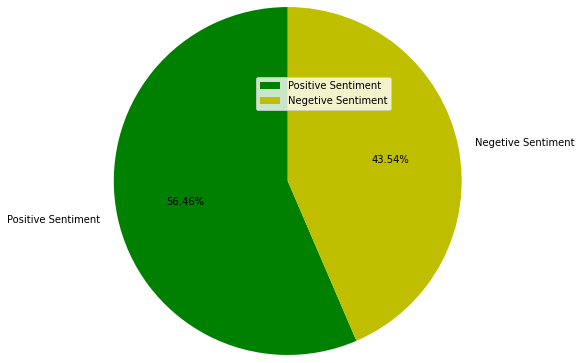

In [ ]:
# Sentiment visualization
sentiment = df.columns.values[1]
sentiments = ['Positive Sentiment', 'Negetive Sentiment'] 
portions = [(df[sentiment] == 1).sum(), (df[sentiment] == 0).sum()] 
colors = ['g', 'y'] 
plt.pie(portions, labels = sentiments, colors=colors, startangle=90, radius = 2, autopct = '%1.2f%%') 
plt.legend()
plt.show() 

In [ ]:
# Record positive, negative sentiment tweets in prep for data visualization
positive_tweets =' '.join([text for text in df['PreProcessed_Tweet'][df[sentiment] == 1]])
negative_tweets =' '.join([text for text in df['PreProcessed_Tweet'][df[sentiment] == 0]])
negative_tweets

' is so sad for my apl friend   missed the new moon trailer   omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins   think mi bf is cheating on me t_t  or just worry too much   sunny again work tomorrow tv tonight  must think about positive   this weekend has sucked so far  jb isnt showing in australia any more   ok thats it you win   lt this is the way feel right now   awhhe man completely useless rt now funny all can do is twitter hx  huge roll of thunder just now so scary   just cut my beard off it only been growing for well over year gonna start it over is happy in the meantime   very sad about iran   wompp wompp  lt sad level is was writing massive blog tweet on myspace and my comp shut down now it all lost lays in fetal position   headed to hospitol had to pull out of the golf tourny in rd place think re ripped something yeah that   boring whats wrong with him please tell me   can be bothered wish could spend the rest of my life just sat

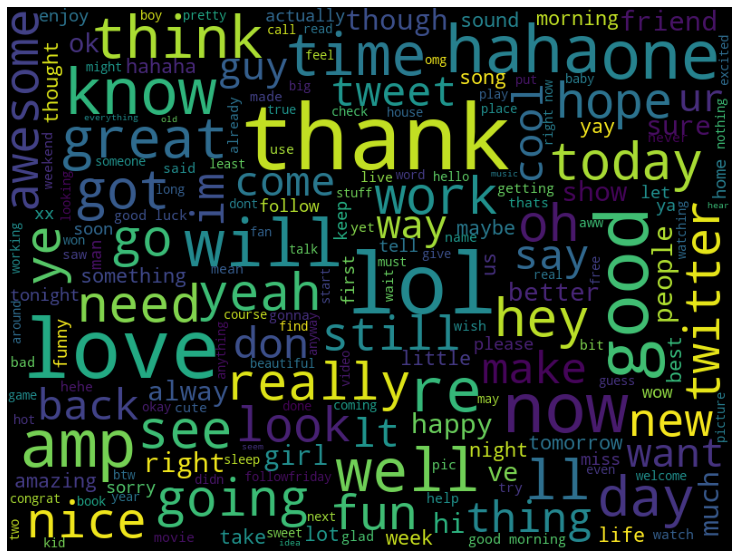

In [ ]:
# Plot word cloud of positive sentiment tweets
wordcloud = WordCloud(width=800, height=600, random_state=101,
            max_font_size=100, mode="RGBA").generate(positive_tweets)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

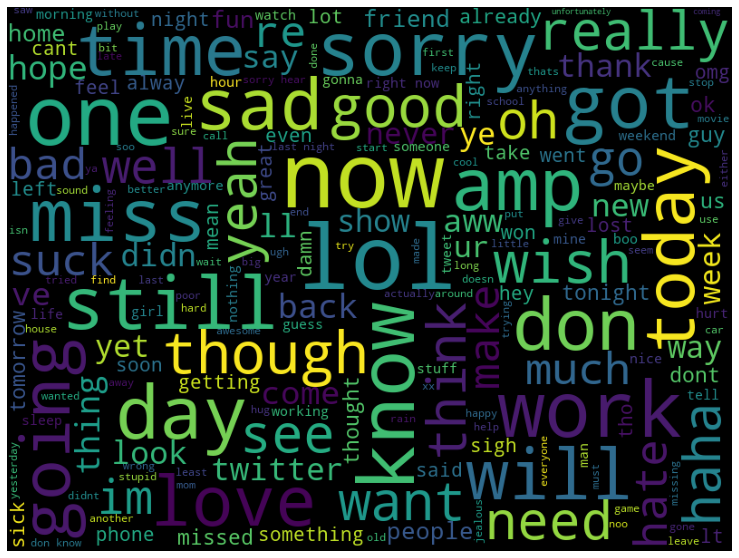

In [ ]:
# Plot word cloud of negative sentiment tweets
wordcloud = WordCloud(width=800, height=600, random_state=101,
            max_font_size=100, mode="RGBA").generate(negative_tweets)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Build classification models

# Extract twitter features from training dataset

In [ ]:
# Extract features using the selected method
# method 0: TF/IDF max 15,000 features
# method 1: TF/IDF use ngrams
# method 2: Count Vectorize
def extract_features(df, method):
  if (method == 0):
    features = TfidfVectorizer(max_features=15000) # shape (28665, 15000)
    X = features.fit_transform(df['Preprocessed_Tweet'].tolist()).toarray()
  elif (method == 1):
    features = TfidfVectorizer(use_idf=True, ngram_range=(1,3))
    X = features.fit_transform(df['Preprocessed_Tweet'])
  elif (method == 2):  
    features = CountVectorizer(ngram_range=(1,2))    # Unigram, Bigram
    X = features.fit_transform(df['PreProcessed_Tweet'])  
  return X

# Extract features from the twitter dataset

In [ ]:
# Extract features given the method
#method = 0                                           # TF/IDF max features 15k
#method = 1                                           # TF/IDF ngrams
method = 2                                            # Use CountVectorize
X = extract_features(df, method)
X.shape

(99989, 462637)

# Reduce dimensions using PCA

# Create train/validate split of all news dataset

In [ ]:
# Split the dataset into training and validation sets - 80/20 splits
y = pd.get_dummies(df['Sentiment'])
y = y.iloc[:,1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 101, stratify=y)

# Train the Naive Bayes classification model

In [ ]:
# Train and predict using Naive Bayes model on the dataset
naive_bayes = MultinomialNB().fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)

print(accuracy_score(y_test, y_pred))
print("\n")

print(confusion_matrix(y_test, y_pred))
print("\n")

print(classification_report(y_test, y_pred))

0.765976597659766


[[6445 2261]
 [2419 8873]]


              precision    recall  f1-score   support

           0       0.73      0.74      0.73      8706
           1       0.80      0.79      0.79     11292

    accuracy                           0.77     19998
   macro avg       0.76      0.76      0.76     19998
weighted avg       0.77      0.77      0.77     19998



In [ ]:
# Train and predict using Naive Bayes model with 10 fold cross validation
naive_bayes_cv = MultinomialNB()
nfold = KFold(n_splits=10, random_state=101, shuffle=True)
scores = cross_val_score(naive_bayes_cv, X, y, cv=nfold)
print(scores)
print(scores.mean())

[0.76407641 0.76607661 0.76637664 0.76977698 0.77277728 0.76847685
 0.77337734 0.76937694 0.76307631 0.76615323]
0.7679544569780041


# Train the Logistic Regression Classification Model

In [ ]:
# Train and predict using Logistic model on the dataset
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.7837783778377838


[[6252 2454]
 [1870 9422]]


              precision    recall  f1-score   support

           0       0.77      0.72      0.74      8706
           1       0.79      0.83      0.81     11292

    accuracy                           0.78     19998
   macro avg       0.78      0.78      0.78     19998
weighted avg       0.78      0.78      0.78     19998



In [ ]:
# Logistic with 10 fold cross validation
logreg = LogisticRegression(solver='liblinear')
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(logreg, X, y, cv=kfold)
print(scores)
print(scores.mean())

[0.77967797 0.77417742 0.78007801 0.78457846 0.7789779  0.77727773
 0.77907791 0.77907791 0.78287829 0.79065813]
0.7806459711784342


# Evaluate the training models

# Evaluate Naive Bayes, Logistic regression models on training data

In [ ]:
# Evaluate the Naive Bayes, Logistic Regression models
models = [LogisticRegression(solver='liblinear'), MultinomialNB()]

# Capture results
collated_results = pd.DataFrame(columns=['models', 'fpr','tpr','auc'])

# Iteratively capture results for different models
for model in models:
    m = model.fit(X_train, y_train)
    yproba = m.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    collated_results = collated_results.append({'models':model.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Index models by name
collated_results.set_index('models', inplace=True)

# Compare and plot ROC/ AUC for different training models

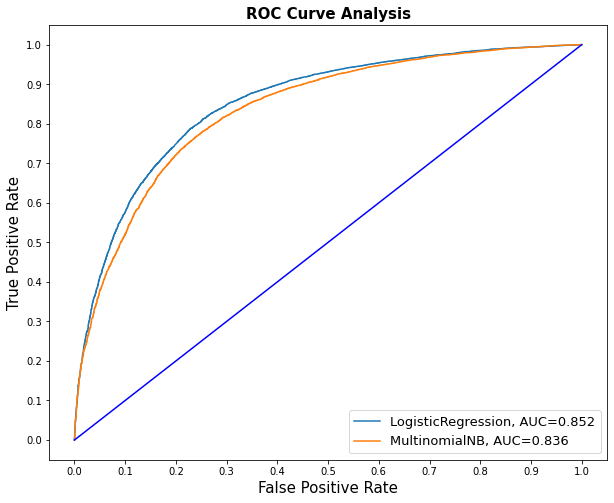

In [ ]:
# Plot the ROC curve for Naive Bayes, Logistic regression models on training data
fig = plt.figure(figsize=(10,8))

# Create collated ROC curves
for k in collated_results.index:
    plt.plot(collated_results.loc[k]['fpr'], 
             collated_results.loc[k]['tpr'], 
             label="{}, AUC={:.3f}".format(k, collated_results.loc[k]['auc']))
   
# Draw the plots
plt.plot([0,1], [0,1], color='blue', linestyle='-')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

# Perform sentiment analysis on test twitter data

# Make predictions of outcome of 2020 US presidential elections 